# Pk Emulator

## PCA+GP Method

In [3]:
import pyccl as ccl
import numpy as np
import pylab as plt
import itertools

import pymaster as nmt

First we want to set up a grid of h and Omega_m spanning across our priors 

In [4]:
w_arr  = np.linspace(0.1, 1, 10)
h_arr  = np.linspace(0.1,  1, 10)

In [5]:
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.049, h=0.67, sigma8=0.81, n_s=0.96)

In [6]:
nk = 100 # No. of points in k
k_arr = np.logspace(-4.7,5,nk)

In [7]:
data = []
for i in range(len(w_arr)):
    for j in range(len(h_arr)):
        cosmo = ccl.Cosmology(Omega_c=w_arr[i], Omega_b=0.049, h=h_arr[j], sigma8=0.81, n_s=0.96)
        data.append(ccl.power.linear_matter_power(cosmo, k_arr, 1))
data = np.array(data)

KeyboardInterrupt: 

In [ ]:
data.shape

Take log and remove mean

In [ ]:
log_data = np.log(data)
log_mean_data = np.log(np.mean(data, axis=0)) #avg over all cosmologies
clean_data = log_data - log_mean_data

In [ ]:
clean_data.shape

Now make PCA to remove number of samples

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(np.transpose(clean_data))

In [ ]:
pca.components_

In [ ]:
for i in range(len(log_data)) :   
    plt.plot( log_data[i], 'b-', alpha=0.3)
plt.plot( log_mean_data, 'r-', label='Log mean data')
plt.xlabel('k', fontsize=15)
plt.ylabel('ln Pk', fontsize=15)
plt.legend()
plt.show()

In [ ]:
for i in range(len(clean_data)):
    plt.plot( clean_data[i], 'b-', alpha=0.2)
plt.xlabel('k', fontsize=15)
plt.ylabel('ln Pk', fontsize=15)
plt.legend()
plt.show()

In [ ]:
 principalComponents = np.transpose( principalComponents)

In [ ]:
plt.plot( principalComponents[0], 'g-',label='PCA1')
plt.plot( principalComponents[1], 'r-',label='PCA2')
plt.plot( principalComponents[2], 'b-',label='PCA3')
plt.plot( principalComponents[3], 'y-',label='PCA4')
plt.plot( log_mean_data, 'k-', label='Log mean data')
plt.xlabel('k', fontsize=15)
plt.ylabel('ln Pk', fontsize=15)
plt.legend()
plt.show()

Now we need to match estimates based on this PC to actual spectra 

In [ ]:
def theory_Pk(weigths , evecs, mean):
    return mean + np.sum(evecs*weigths, axis=0)

In [ ]:
weigths1 = np.array([[1],[0],[1],[0]])
prediction1 = theory_Pk(weigths1, principalComponents, log_mean_data)
weigths2 = np.array([[0],[1],[0],[1]])
prediction2 = theory_Pk(weigths2, principalComponents, log_mean_data)

In [ ]:
plt.plot( prediction1, 'r--',label='Theory 1')
plt.plot( prediction2, 'g--',label='Theory 2')
plt.plot( log_mean_data, 'b-',label='Log mean Pk')
plt.xlabel('k', fontsize=15)
plt.ylabel('ln Pk', fontsize=15)
plt.legend()
plt.show()

## Interpolation Method

In [116]:
import scipy
import pyccl as ccl
import numpy as np
import pylab as plt
import itertools
import pickle

class Lin_Pk_emulator:
    def __init__(self, n_train, n_k, new = False):
        
        self.k_arr = np.logspace(-4.7,5, n_k)
        self.wc_arr  = np.linspace(0.1, 1, n_train)
        self.h_arr  = np.linspace(0.1,  1, n_train)
        
        if new:
            self.Pk_emulator_arr = {}
            for k in self.k_arr:  
                print(k)
                self.Pk_arr  = self.__theory_Pk(k, self.wc_arr, self.h_arr)
                self.Pk_emulator = scipy.interpolate.interp2d(self.h_arr, self.wc_arr, self.Pk_arr, kind='cubic')
                self.Pk_emulator_arr["{}".format(k)]= self.Pk_emulator
                
            with open('Pk_emulator_arr'+'.pkl', 'wb') as f:
                pickle.dump(self.Pk_emulator_arr, f, pickle.HIGHEST_PROTOCOL)

        else:
            self.Pk_emulator_arr = self.__load_emulator()
            
        return 
            
    ###############
    #PRIVATE METHODS
    ###############
    
    def __theory_Pk(self, k, wc_arr, h_arr):
        output = []
        for i in range(len(wc_arr)):
            row = []
            for j in range(len(h_arr)):
                cosmo = ccl.Cosmology(Omega_c=wc_arr[i], Omega_b=0.049, h=h_arr[j], sigma8=0.81, n_s=0.96)
                row.append(np.log(ccl.power.linear_matter_power(cosmo, k, 1)))
            output.append(np.array(row))
        return np.array(output) 
    
    def __load_emulator(self):
        with open('Pk_emulator_arr'+ '.pkl', 'rb') as f:
            return pickle.load(f)
    
    ###############
    #PUBLIC METHODS
    ###############
    
    def get_Pk(self, h, wc):
        #log lin_Pk
        self.Pk = []
        for k in self.k_arr:
            self.Pk_k=self.Pk_emulator_arr["{}".format(k)](h, wc)[0]
            self.Pk.append(self.Pk_k)
            
        return self.k_arr, np.array(self.Pk)
        

In [122]:
test = Lin_Pk_emulator(5, 10, new=True)

1.9952623149688786e-05
0.00023865897868585785
0.00285466766349793
0.034145488738336005
0.4084238652674517
4.885273571519382
58.434141337351754
698.9473207273479
8360.306936514631
100000.0


In [137]:
k_arr, Pk_emulated = test.get_Pk(0.3, 0.76)
cosmo = ccl.Cosmology(Omega_c=0.3, Omega_b=0.049, h=0.76, sigma8=0.81, n_s=0.96)
#k_arr = np.logspace(-4.7,5, 5)
Pk_theory = np.log(ccl.power.linear_matter_power(cosmo, k_arr, 1))

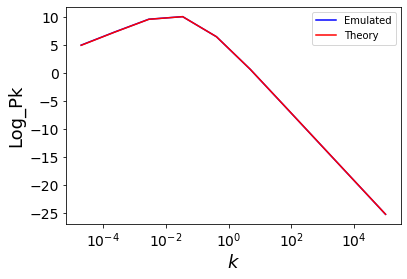

In [138]:
plt.plot(k_arr, Pk_emulated, 'b-', label = 'Emulated')
plt.plot(k_arr, Pk_theory, 'r-', label = 'Theory')
plt.legend()
plt.xlabel('$k$',fontsize=18)
plt.ylabel('Log_Pk',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xscale('log')
plt.show()

In [143]:
Pk_diff = 100*abs(Pk_emulated-Pk_theory)/Pk_theory

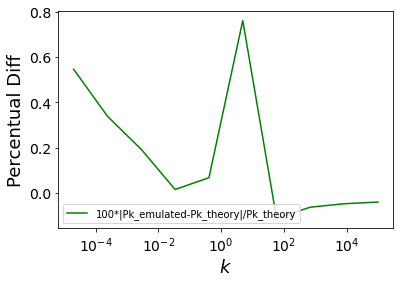

In [149]:
plt.plot(k_arr, Pk_diff, 'g-', label = '100*|Pk_emulated-Pk_theory|/Pk_theory' )
plt.xlabel('$k$',fontsize=18)
plt.ylabel('Percentual Diff',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xscale('log')
plt.legend(loc="lower left")
plt.show()